In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 8.4 MB/s eta 0:00:00


In [2]:
!pip install lightgbm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import shap
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import seaborn as sns

In [4]:
virus_df = pd.read_csv('drive/MyDrive/ColabNotebooks/UMA/virus_df_full_only_age.csv').drop(['Country', 'Age', 'Health_Status', 'Archaeal', 'Bacteriophage', 'Eukaryotic', 'crassphage'], axis=1)

In [7]:
import numpy as np
rand_vals = np.random.randint(0, 101, size=len(virus_df))

virus_df['random_col'] = rand_vals

In [8]:
virus_df.head()

,Healthy,Ackermannviridae,Adenoviridae,Alphaflexiviridae,Anelloviridae,Asfarviridae,Astroviridae,Bicaudaviridae,Caliciviridae,Circoviridae,...,Rudiviridae,Siphoviridae,Smacoviridae,Virgaviridae,Age_Child,Age_Adult,Age_Infant,Age_Elderly,Age_Mix,random_col
0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,1,0,0,0,0,19
1,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,1,0,0,0,0,88
2,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,1,0,0,0,0,64
3,1.0,0.0,0.0,0.0,3.84,0.0,0.0,0.0,0.0,0.0,...,0.0,3.84,0.0,0.0,1,0,0,0,0,60
4,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,1,0,0,0,0,86


In [9]:
target = 'Healthy'

X = virus_df.loc[:,virus_df.columns!=target]
y = virus_df.loc[:,virus_df.columns==target]

In [10]:
oversample = SMOTE(random_state=42, k_neighbors=20)
X, y = oversample.fit_resample(X, y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [12]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [13]:
rf.fit(X_train, y_train.values.ravel())

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


RandomForestClassifier(max_features='auto', n_estimators=150, n_jobs=-1,
                       random_state=123)

In [14]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

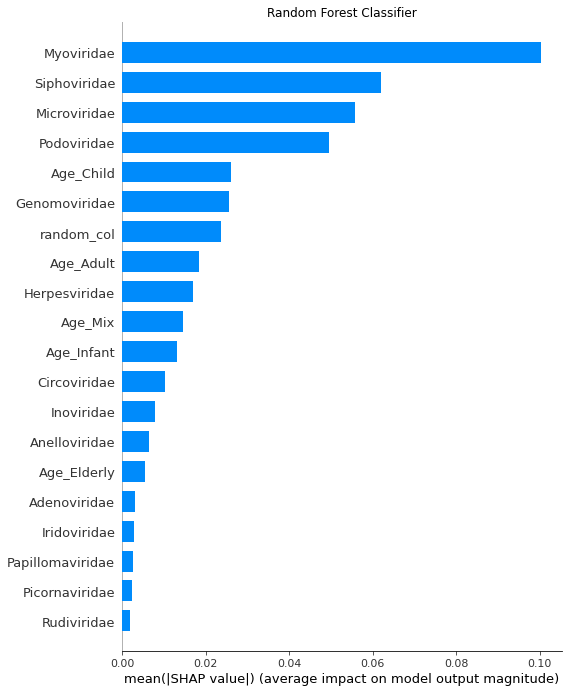

In [15]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=False)
plt.title("Random Forest Classifier")
plt.show()

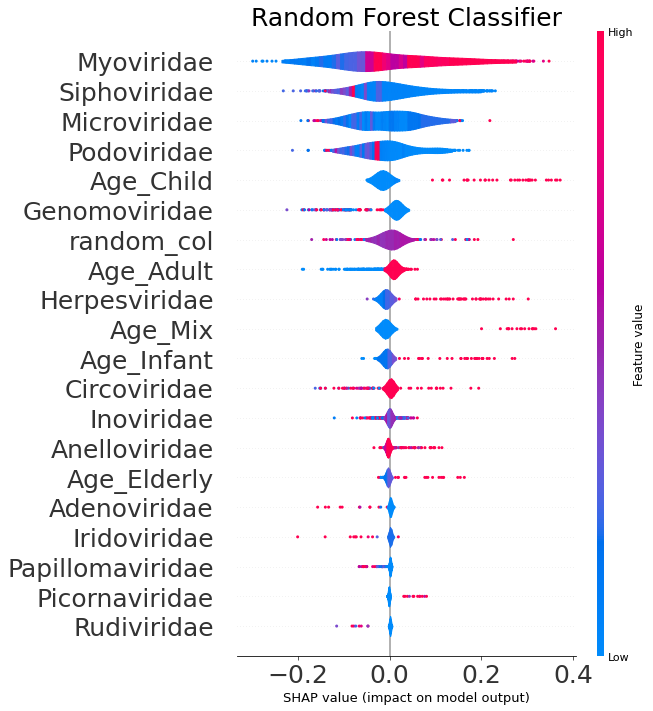

In [16]:
shap.summary_plot(shap_values[1], X_test, plot_type='violin', show=False)
plt.title("Random Forest Classifier", fontsize=25)
plt.tick_params(labelsize=25)
plt.show()

In [17]:
y_predicted = rf.predict(X_test)

In [18]:
y_pred_rf = y_predicted

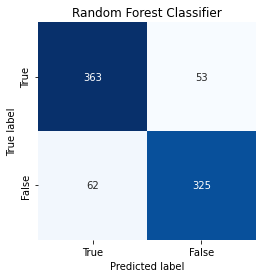

In [19]:
mat = confusion_matrix(y_test, y_predicted)
labels = ['True', 'False']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Random Forest Classifier")
plt.show()

In [20]:
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)

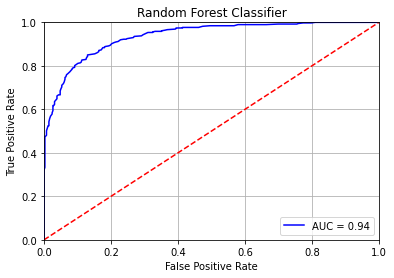

In [21]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Random Forest Classifier")
plt.show()

In [22]:
print('Random Forest')
# Display accuracy score
accuracy=accuracy_score(y_test, y_predicted)
# Display F1 score
f1=f1_score(y_test,y_predicted)
# Display recall
rcl = recall_score(y_test,y_predicted)
# Display precision
prcs = precision_score(y_test,y_predicted)

print(f'Accuracy = {accuracy}\nF1 = {f1}\nRecall = {rcl}\nPrecision = {prcs}')

Random Forest
Accuracy = 0.8567870485678705
F1 = 0.8496732026143791
Recall = 0.8397932816537468
Precision = 0.8597883597883598


extra tree

In [23]:
et = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                                  criterion='gini', max_depth=None, max_features='auto',
                                  max_leaf_nodes=None, max_samples=None,
                                  min_impurity_decrease=0.0,
                                  min_samples_leaf=1, min_samples_split=2,
                                  min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                                  oob_score=False, random_state=123, verbose=0,
                                  warm_start=False)

In [24]:
et.fit(X_train, y_train.values.ravel())

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


ExtraTreesClassifier(max_features='auto', n_estimators=150, n_jobs=-1,
                     random_state=123)

In [25]:
explainer = shap.TreeExplainer(et)
shap_values = explainer.shap_values(X_test)

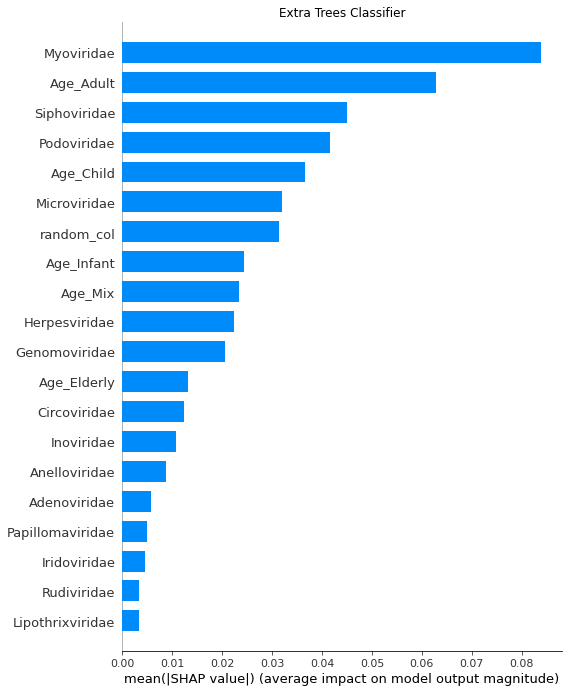

In [26]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=False)
plt.title("Extra Trees Classifier")
plt.show()

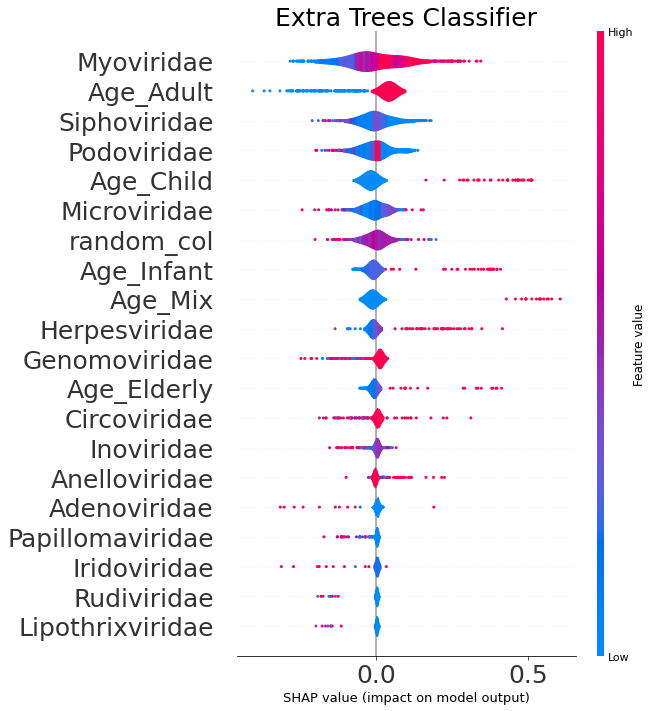

In [27]:
shap.summary_plot(shap_values[1], X_test, plot_type='violin', show=False)
plt.title("Extra Trees Classifier", fontsize=25)
plt.tick_params(labelsize=25)
plt.show()

In [28]:
y_predicted = et.predict(X_test)

In [29]:
y_pred_et = y_predicted

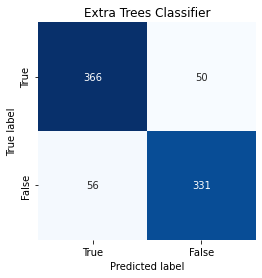

In [30]:
mat = confusion_matrix(y_test, y_predicted)
labels = ['True', 'False']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Extra Trees Classifier")
plt.show()

In [31]:
probs = et.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)

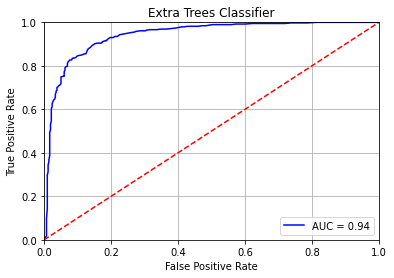

In [32]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Extra Trees Classifier")
plt.show()

In [33]:
print('Extra tree')
# Display accuracy score
accuracy=accuracy_score(y_test, y_predicted)
# Display F1 score
f1=f1_score(y_test,y_predicted)
# Display recall
rcl = recall_score(y_test,y_predicted)
# Display precision
prcs = precision_score(y_test,y_predicted)

print(f'Accuracy = {accuracy}\nF1 = {f1}\nRecall = {rcl}\nPrecision = {prcs}')

Extra tree
Accuracy = 0.8679950186799502
F1 = 0.8619791666666666
Recall = 0.8552971576227391
Precision = 0.868766404199475


lightgbm 

In [34]:
lightgbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                              importance_type='split', learning_rate=0.1, max_depth=-1,
                              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                              n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
                              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
lightgbm.fit(X_train, y_train.values.ravel())

LGBMClassifier(n_estimators=150, random_state=123, silent='warn')

In [36]:
explainer = shap.TreeExplainer(lightgbm)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


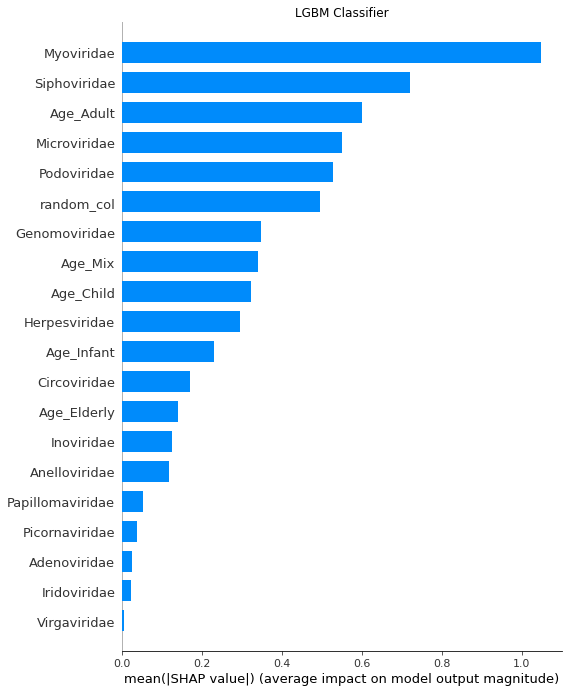

In [37]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=False)
plt.title("LGBM Classifier")
plt.show()

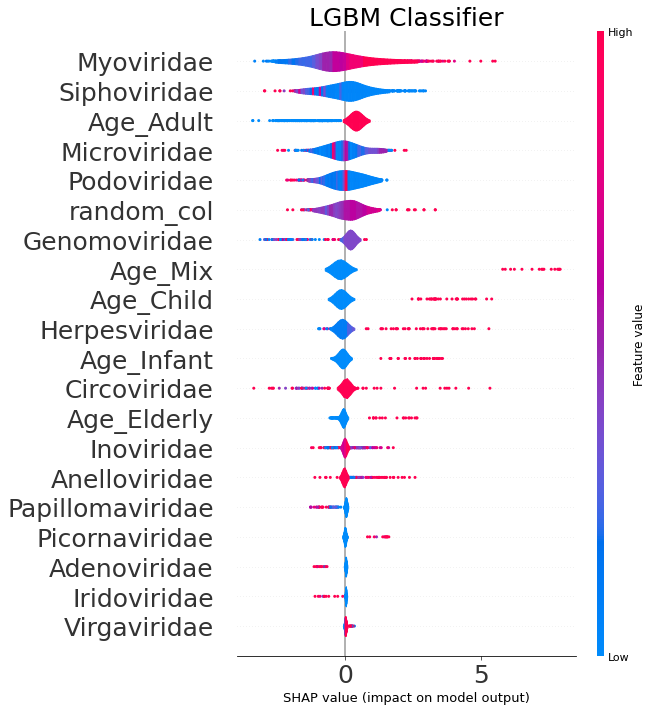

In [38]:
shap.summary_plot(shap_values[1], X_test, plot_type='violin', show=False)
plt.title("LGBM Classifier", fontsize=25)
plt.tick_params(labelsize=25)
plt.show()

In [39]:
y_predicted = lightgbm.predict(X_test)

In [40]:
y_pred_lgbm = y_predicted

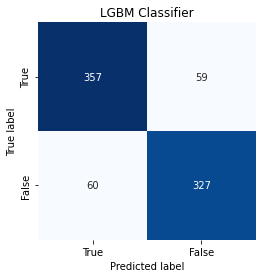

In [41]:
mat = confusion_matrix(y_test, y_predicted)
labels = ['True', 'False']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("LGBM Classifier")
plt.show()

In [42]:
probs = lightgbm.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)

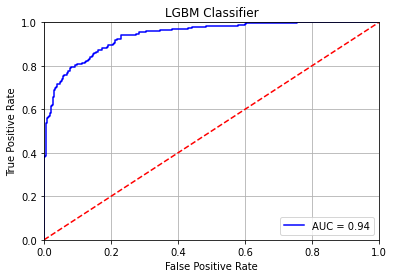

In [43]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("LGBM Classifier")
plt.show()

In [44]:
pred_df = pd.DataFrame()
pred_df['RF'] = y_pred_rf
pred_df['ET'] = y_pred_et
pred_df['LGBM'] = y_pred_lgbm

pred_df['target'] = pred_df.mode(axis=1)[0]
pred_df.head()

,RF,ET,LGBM,target
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [45]:
print(f"Accuracy = {accuracy_score(y_test, pred_df['target'])}")
print(f"Confusion matrix \n{confusion_matrix(y_test, pred_df['target'])}")

Accuracy = 0.8605230386052304
Confusion matrix 
[[362  54]
 [ 58 329]]
